In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# Cleaning

In [ ]:
df = pd.read_csv('/content/Ask-A-Manager-Salary-Survey-2021-Responses-Form-Responses-1.csv')
print(df.shape)
df.head()

(27508, 18)


,Timestamp,How old are you?,Industry,Job title,Additional context on job title,Annual salary,Other monetary comp,Currency,Currency - other,Additional context on income,Country,State,City,Overall years of professional experience,Years of experience in field,Highest level of education completed,Gender,Race
0,4/27/2021 11:02:10,25-34,Education (Higher Education),Research and Instruction Librarian,NaN,"55,000",0.0,USD,NaN,NaN,United States,Massachusetts,Boston,5-7 years,5-7 years,Master's degree,Woman,White
1,4/27/2021 11:02:22,25-34,Computing or Tech,Change & Internal Communications Manager,NaN,"54,600",4000.0,GBP,NaN,NaN,United Kingdom,NaN,Cambridge,8 - 10 years,5-7 years,College degree,Non-binary,White
2,4/27/2021 11:02:38,25-34,"Accounting, Banking & Finance",Marketing Specialist,NaN,"34,000",NaN,USD,NaN,NaN,US,Tennessee,Chattanooga,2 - 4 years,2 - 4 years,College degree,Woman,White
3,4/27/2021 11:02:41,25-34,Nonprofits,Program Manager,NaN,"62,000",3000.0,USD,NaN,NaN,USA,Wisconsin,Milwaukee,8 - 10 years,5-7 years,College degree,Woman,White
4,4/27/2021 11:02:42,25-34,"Accounting, Banking & Finance",Accounting Manager,NaN,"60,000",7000.0,USD,NaN,NaN,US,South Carolina,Greenville,8 - 10 years,5-7 years,College degree,Woman,White


In [ ]:
df.columns = ['date', 'age', 'industry', 'job', 'context', 
              'wage', 'money_component', 'currency', 'other_currency', 'income_context', 
              'country', 'state', 'city', 'experience', 'actual_experience',
              'education', 'gender', 'race']

df.head()

,date,age,industry,job,context,wage,money_component,currency,other_currency,income_context,country,state,city,experience,actual_experience,education,gender,race
0,4/27/2021 11:02:10,25-34,Education (Higher Education),Research and Instruction Librarian,NaN,"55,000",0.0,USD,NaN,NaN,United States,Massachusetts,Boston,5-7 years,5-7 years,Master's degree,Woman,White
1,4/27/2021 11:02:22,25-34,Computing or Tech,Change & Internal Communications Manager,NaN,"54,600",4000.0,GBP,NaN,NaN,United Kingdom,NaN,Cambridge,8 - 10 years,5-7 years,College degree,Non-binary,White
2,4/27/2021 11:02:38,25-34,"Accounting, Banking & Finance",Marketing Specialist,NaN,"34,000",NaN,USD,NaN,NaN,US,Tennessee,Chattanooga,2 - 4 years,2 - 4 years,College degree,Woman,White
3,4/27/2021 11:02:41,25-34,Nonprofits,Program Manager,NaN,"62,000",3000.0,USD,NaN,NaN,USA,Wisconsin,Milwaukee,8 - 10 years,5-7 years,College degree,Woman,White
4,4/27/2021 11:02:42,25-34,"Accounting, Banking & Finance",Accounting Manager,NaN,"60,000",7000.0,USD,NaN,NaN,US,South Carolina,Greenville,8 - 10 years,5-7 years,College degree,Woman,White


In [ ]:
print('The perc. of empty values')
for column_name in df:
    percentage_na = df[column_name].isna().mean() * 100
    print(f'{column_name} : {np.round(percentage_na)} %')

The perc. of empty values
date : 0.0 %
age : 0.0 %
industry : 0.0 %
job : 0.0 %
context : 74.0 %
wage : 0.0 %
money_component : 26.0 %
currency : 0.0 %
other_currency : 99.0 %
income_context : 89.0 %
country : 0.0 %
state : 18.0 %
city : 0.0 %
experience : 0.0 %
actual_experience : 0.0 %
education : 1.0 %
gender : 1.0 %
race : 1.0 %


We can notice that 'context', 'money_component' 'other_currency', 'income_context' have a lot of missing values. Moreover, they did not give us relevent information in our process. Thus we can just drop them. 

About the state feature, it could be interesting to exploit it event if we have 18% missing value. Thus, for the time being we will keep those rows, and when it will be time to deal with this data we will drop the missing rows. 

Finally, with a rate of 1% missing values, we can drop the rows concerned by education, gender and race missing value without any risk of bias.

In [ ]:
drop_columns = ['context','money_component','other_currency','income_context']
df = df.drop(drop_columns,1)
df.shape

(27508, 14)

In [ ]:
mask_nan = (df['education'].isna().values | df['gender'].isna().values | df['race'].isna().values)
df = df[~mask_nan].reset_index(drop=True)

numbers_rows = df.shape[0]
numbers_columns = df.shape[1]

print(f'Building metadata without na rows except for state : {numbers_rows} | columns : {numbers_columns}')

Building metadata without na rows except for state : 27079 | columns : 14


In [ ]:
df.describe()

,date,age,industry,job,wage,currency,country,state,city,experience,actual_experience,education,gender,race
count,27079,27079,27013,27079,27079,27079,27079,22298,27004,27079,27079,27079,27079,27079
unique,24369,7,1181,13927,4183,11,359,129,4681,8,8,6,5,48
top,4/27/2021 11:05:17,25-34,Computing or Tech,Software Engineer,"60,000",USD,United States,California,Boston,11 - 20 years,11 - 20 years,College degree,Woman,White
freq,5,12196,4518,275,423,22593,8716,2526,751,9347,6360,13136,20834,22646


Moreover, we can notice that there's 359 unique values for country feature. However, our study is focus on United States so let's check that.

In [ ]:
print(df['country'].unique())

['United States' 'United Kingdom' 'US' 'USA' 'Canada' 'United Kingdom '
 'usa' 'UK' 'Scotland ' 'U.S.' 'United States ' 'The Netherlands'
 'Australia ' 'Spain' 'us' 'Usa' 'England' 'finland'
 'United States of America' 'France' 'United states' 'Scotland' 'USA '
 'United states ' 'Germany' 'UK ' 'united states' 'Ireland' 'India'
 'Australia' 'Uk' 'United States of America ' 'U.S. ' 'canada' 'Canada '
 'U.S>' 'ISA' 'Argentina' 'Great Britain ' 'US ' 'United State' 'U.S.A'
 'Denmark' 'U.S.A.' 'America' 'Netherlands' 'netherlands' 'England '
 'united states of america' 'Ireland ' 'Switzerland' 'Netherlands '
 'Bermuda' 'Us' 'The United States' 'United State of America' 'Malaysia'
 'Mexico ' 'United Stated' 'South Africa ' 'Belgium' 'Northern Ireland'
 'u.s.' 'South Africa' 'UNITED STATES' 'united States' 'Sweden'
 'Hong Kong' 'Kuwait' 'Norway' 'Sri lanka' 'Contracts'
 'USA-- Virgin Islands' 'United Statws' 'England/UK' 'U.S'
 "We don't get raises, we get quarterly bonuses, but they periodi

In [ ]:
df1 = df[df['country'].str.startswith('u')] 
df1 = df1[df1["country"].str.contains("s|S")]

df2 = df[df['country'].str.startswith('U')]
df2 = df2[df2["country"].str.contains("s|S")]

df_try2 = pd.concat([df1, df2])
print(df_try2['country'].unique())

['usa' 'us' 'united states' 'united states of america' 'u.s.'
 'united States' 'united states ' 'united stated' 'usa ' 'uSA' 'uS'
 'United States' 'US' 'USA' 'U.S.' 'United States ' 'Usa'
 'United States of America' 'United states' 'USA ' 'United states '
 'United States of America ' 'U.S. ' 'U.S>' 'US ' 'United State' 'U.S.A'
 'U.S.A.' 'Us' 'United State of America' 'United Stated' 'UNITED STATES'
 'USA-- Virgin Islands' 'United Statws' 'U.S' 'Unites States ' 'Usa '
 'U.S.A. ' 'U. S. ' 'United Sates' 'United States of American '
 'Uniited States' 'United Sates of America'
 'United States (I work from home and my clients are all over the US/Canada/PR'
 'Unted States' 'United Statesp' 'United Stattes' 'United Statea'
 'Unites States' 'United Statees' 'Uniyed states' 'Uniyes States'
 'United States of Americas' 'U. S.' 'US of A' 'United States of america '
 'United Arab Emirates ' 'U.SA' 'United Status' 'U.s.' 'U.s.a.' 'USS'
 'Uniteed States' 'United Stares' 'UK for U.S. company' 'Unites

After this first filter which selected all the countries's name starting by the letter u, we have to drop those different from our target country. 

We can easly removed UK by filtering countries that contains the letter k.

In [ ]:
df_try2 = df_try2[~(df_try2['country'].str.contains('K|k|Emirates'))]

In [ ]:
print(df_try2.shape)
print(df_try2['country'].unique())

(22383, 14)
['usa' 'us' 'united states' 'united states of america' 'u.s.'
 'united States' 'united states ' 'united stated' 'usa ' 'uSA' 'uS'
 'United States' 'US' 'USA' 'U.S.' 'United States ' 'Usa'
 'United States of America' 'United states' 'USA ' 'United states '
 'United States of America ' 'U.S. ' 'U.S>' 'US ' 'United State' 'U.S.A'
 'U.S.A.' 'Us' 'United State of America' 'United Stated' 'UNITED STATES'
 'USA-- Virgin Islands' 'United Statws' 'U.S' 'Unites States ' 'Usa '
 'U.S.A. ' 'U. S. ' 'United Sates' 'United States of American '
 'Uniited States' 'United Sates of America' 'Unted States'
 'United Statesp' 'United Stattes' 'United Statea' 'Unites States'
 'United Statees' 'Uniyed states' 'Uniyes States'
 'United States of Americas' 'U. S.' 'US of A' 'United States of america '
 'U.SA' 'United Status' 'U.s.' 'U.s.a.' 'USS' 'Uniteed States'
 'United Stares' 'Unites states ' 'Us ' 'Unite States'
 'United states of America ' 'UnitedStates' 'United States of america'
 'United sta

In [ ]:
df_try2[df_try2['currency'] != 'USD']['currency'].count() #We count the number of rows that do not have 'USD' as currency.

22

We only have 22 rows that do not have 'USD' as currency, so we can delete them


In [ ]:
df_try2 = df_try2[df_try2['currency'] == 'USD']

# Statistical analysis

Now that our datas are clean, we can do some statistics to better understand them. 

In [ ]:
df = df_try2
df = df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22361 entries, 0 to 22360
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   date               22361 non-null  object
 1   age                22361 non-null  object
 2   industry           22310 non-null  object
 3   job                22361 non-null  object
 4   wage               22361 non-null  object
 5   currency           22361 non-null  object
 6   country            22361 non-null  object
 7   state              22206 non-null  object
 8   city               22303 non-null  object
 9   experience         22361 non-null  object
 10  actual_experience  22361 non-null  object
 11  education          22361 non-null  object
 12  gender             22361 non-null  object
 13  race               22361 non-null  object
dtypes: object(14)
memory usage: 2.4+ MB


We can remark that our data are object type and that the annual salary is given with a coma to separate "les milliers et le reste". So we have to fix that to exploit data.

In [ ]:
df = df.apply(lambda x: x.str.replace(',',''))

In [ ]:
df_wage = df['wage'].astype(str).astype(int)
df['wage']=df_wage

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22361 entries, 0 to 22360
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   date               22361 non-null  object
 1   age                22361 non-null  object
 2   industry           22310 non-null  object
 3   job                22361 non-null  object
 4   wage               22361 non-null  int64 
 5   currency           22361 non-null  object
 6   country            22361 non-null  object
 7   state              22206 non-null  object
 8   city               22303 non-null  object
 9   experience         22361 non-null  object
 10  actual_experience  22361 non-null  object
 11  education          22361 non-null  object
 12  gender             22361 non-null  object
 13  race               22361 non-null  object
dtypes: int64(1), object(13)
memory usage: 2.4+ MB


Looking at the wage statistics we observed that some data doesn't hold water. Indeed  people with 5 millions revenu per year are exceptions or didn't tell the truth, or made a mistake when they filled the survey, and those who have 0$ salaray didn't work, thus they're not our target.
Therefore, we have to filter on wage to have some coherence. 

In [ ]:
#initial wage statistic
print('\n Initial wage statistic:')
print('Number of data:',df.wage.count())
print('Minimum salary:',df.wage.min())
print('Maximum salary:',df.wage.max())

#more statistics after filtered
print('\n statistics after filtered:')
df = df[(df.wage<500000)&(df.wage>15000)] #better define limitations ?
print('Number of data:',df.wage.count())
print('Minimum salary:',df.wage.min())
print('Maximum salary:',df.wage.max())
print('Average salary:',df.wage.mean())
print('Median salary:',df.wage.median())
print('Variance salary:',np.var(df.wage))
print('Standard deviation salary:',df.wage.std())


 Initial wage statistic:
Number of data: 22361
Minimum salary: 0
Maximum salary: 5000044

 statistics after filtered:
Number of data: 22203
Minimum salary: 15080
Maximum salary: 499945
Average salary: 90567.34148538485
Median salary: 78998.0
Variance salary: 2395715923.049462
Standard deviation salary: 48947.15342550497


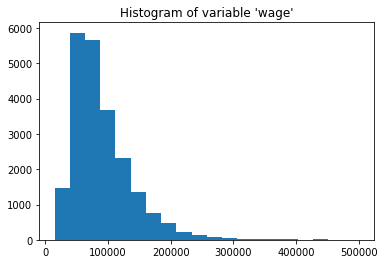

In [ ]:
plt.hist(df.wage,bins=20)
plt.title("Histogram of variable 'wage'")
plt.show()

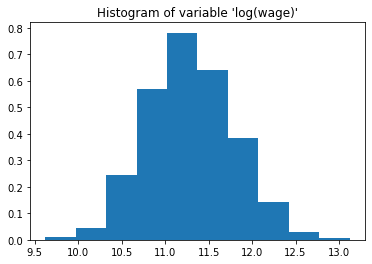

In [ ]:
plt.hist(np.log(df.wage),density=True)
plt.title("Histogram of variable 'log(wage)'")
plt.show()

Pour l'age, l'expérience et l'expérience actuelle on remplace chaque catégorie par la valeur de sa moyenne (qui est ici égale à la médianne car on suppose que l'échantillon est équi-répartie au sein d'un groupe). Pour le genre et le niveau d'éducation on attibut à chaques catégories un numéro de référence. On cast chaque column en un type float afin de pouvoir calculer la matrice de corrélation par la suite. 

In [ ]:
print((df.groupby('age').size()/df['age'].count())*100)

df.loc[df['age'] == '18-24', 'age'] = 21
df.loc[df['age'] == '25-34', 'age'] = 29.5
df.loc[df['age'] == '35-44', 'age'] = 39.5
df.loc[df['age'] == '45-54', 'age'] = 49.5
df.loc[df['age'] == '55-64', 'age'] = 59.5
df.loc[df['age'] == '65 or over', 'age'] = 70
df.loc[df['age'] == 'under 18', 'age'] = 16.5

df_age = df['age'].astype(float)
df['age']=df_age

#attribuer à chaque groupe d'age la valeur de la médiane du groupe, puis tracer un histogramme de l'age
#on peut commenter que le fait d'avoir l'age précis des personnes aurait était plus précis

age
18-24          4.003963
25-34         44.408413
35-44         35.891546
45-54         11.588524
55-64          3.706706
65 or over     0.364816
under 18       0.036031
dtype: float64


In [ ]:
print((df.groupby('education').size()/df['education'].count())*100)

df.loc[df['education'] == 'High School', 'education'] = 0
df.loc[df['education'] == 'Some college', 'education'] = 1
df.loc[df['education'] == 'College degree', 'education'] = 2
df.loc[df['education'] == 'Professional degree (MD JD etc.)', 'education'] = 3
df.loc[df['education'] == "Master's degree", 'education'] = 4
df.loc[df['education'] == 'PhD', 'education'] = 5

df_edu = df['education'].astype(float)
df['education']=df_edu

education
College degree                      48.975364
High School                          1.756519
Master's degree                     32.495609
PhD                                  4.819169
Professional degree (MD JD etc.)     4.931766
Some college                         7.021574
dtype: float64


In [ ]:
print((df.groupby('experience').size()/df['experience'].count())*100)

df.loc[df['experience'] == '1 year or less', 'experience'] = 0.5
df.loc[df['experience'] == '11 - 20 years', 'experience'] = 15.5
df.loc[df['experience'] == '2 - 4 years', 'experience'] = 3
df.loc[df['experience'] == '21 - 30 years', 'experience'] = 25.5
df.loc[df['experience'] == '31 - 40 years', 'experience'] = 35.5
df.loc[df['experience'] == '41 years or more', 'experience'] = 45.5
df.loc[df['experience'] == '8 - 10 years', 'experience'] = 9
df.loc[df['experience'] == '5-7 years', 'experience'] = 6

df_exp = df['experience'].astype(float)
df['experience']=df_exp

experience
1 year or less       1.639418
11 - 20 years       35.031302
2 - 4 years         10.250867
21 - 30 years       13.191911
31 - 40 years        3.152727
41 years or more     0.477413
5-7 years           17.101293
8 - 10 years        19.155069
dtype: float64


In [ ]:
print((df.groupby('actual_experience').size()/df['actual_experience'].count())*100)

df.loc[df['actual_experience'] == '1 year or less', 'actual_experience'] = 0.5
df.loc[df['actual_experience'] == '11 - 20 years', 'actual_experience'] = 15.5
df.loc[df['actual_experience'] == '2 - 4 years', 'actual_experience'] = 3
df.loc[df['actual_experience'] == '21 - 30 years', 'actual_experience'] = 25.5
df.loc[df['actual_experience'] == '31 - 40 years', 'actual_experience'] = 35.5
df.loc[df['actual_experience'] == '41 years or more', 'actual_experience'] = 45.5
df.loc[df['actual_experience'] == '8 - 10 years', 'actual_experience'] = 9
df.loc[df['actual_experience'] == '5-7 years', 'actual_experience'] = 6



df_ae = df['actual_experience'].astype(float)
df['actual_experience']=df_ae

#df['actual_experience'] = df['actual_experience'].replace('1 year or less', 0).replace('11 - 20 years', 1).replace('2 - 4 years', 2).replace('21 - 30 years', 3).replace('31 - 40 years', 4).replace('41 years or more', 5).replace('5-7 years', 6).replace('8 - 10 years ', 7)


actual_experience
1 year or less       4.810161
11 - 20 years       23.789578
2 - 4 years         21.393505
21 - 30 years        6.823402
31 - 40 years        1.427735
41 years or more     0.139621
5-7 years           23.537360
8 - 10 years        18.078638
dtype: float64


Maintenant on regarde les variables non numérique : gender, race, state, industry. 

In [ ]:
print((df.groupby('gender').size()/df['gender'].count())*100)

df.loc[df['gender'] == 'Woman', 'gender'] = 0
df.loc[df['gender'] == 'Man', 'gender'] = 1
df.loc[df['gender'] == 'Non-binary', 'gender'] = 2
df.loc[df['gender'] == 'Other or prefer not to answer', 'gender'] = 3
df.loc[df['gender'] == 'Prefer not to answer', 'gender'] = 3

df_gender = df['gender'].astype(float)
df['gender']=df_gender

#lorsqu'on voudra étudier des métriques qui dépendent du genre
#voir combien de autre que woman and man, et supprimé les row correspondant si (et surment) trop peu de % car ça sera pas relevant

#Je pense qu'il faut faire 3 data frame : 1 avec tout / 1 sans les genres différents de ceux usuels / 1 sans les states/city pour utiliser le bon df à chq fois

gender
Man                              18.173220
Non-binary                        2.616764
Other or prefer not to answer     0.954826
Prefer not to answer              0.004504
Woman                            78.250687
dtype: float64


In [ ]:
((df.groupby('race').size()/df['race'].count())*100).sort_values(ascending = False).head(5) #94.89%

race = ['White','Asian or Asian American','Black or African American','Hispanic Latino or Spanish origin','Another option not listed here or prefer not to answer']
df_race = df[df.race.isin(race)]

df_race.loc[df['race'] == 'White', 'race'] = 0
df_race.loc[df['race'] == 'Asian or Asian American', 'race'] = 1
df_race.loc[df['race'] == 'Black or African American', 'race'] = 2
df_race.loc[df['race'] == 'Hispanic Latino or Spanish origin', 'race'] = 3
df_race.loc[df['race'] == 'Another option not listed here or prefer not to answer', 'race'] = 4

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


En prenant la liste des 51 réponses les plus représentés, on arrive à avoir 51 des 52 états, donc aucun doublons. En effet le fait que certaines personnes aient entré à la main l'information fait qu'on perd des informatiosn du au différentes possibilités d'écriture. Ici la liste qu'on obtient représente 99.5% des réponses, la perte d'information est minimales.
(add .sum() à ligne suivante).

In [ ]:
((df.groupby('state').size()/df['state'].count())*100).sort_values(ascending = False).head(51)

state
California              11.301587
New York                 9.451247
Massachusetts            6.671202
Texas                    5.433107
Illinois                 5.247166
Washington               5.174603
District of Columbia     4.258503
Pennsylvania             4.117914
Virginia                 3.428571
Minnesota                3.147392
Ohio                     2.820862
Oregon                   2.752834
Colorado                 2.730159
North Carolina           2.634921
Maryland                 2.448980
Michigan                 2.371882
Georgia                  2.290249
Florida                  2.263039
Wisconsin                2.040816
New Jersey               1.687075
Missouri                 1.460317
Indiana                  1.392290
Arizona                  1.342404
Tennessee                1.247166
Connecticut              1.043084
Utah                     0.911565
Kentucky                 0.802721
Iowa                     0.789116
Kansas                   0.662132
South Ca

In [ ]:
state = ['California','New York','Massachusetts','Texas','Illinois','Washington','District of Columbia','Pennsylvania','Virginia','Minnesota','Ohio','Oregon','Colorado','North Carolina','Maryland','Michigan','Georgia','Florida','Wisconsin','New Jersey','Missouri','Indiana','Arizona','Tennessee','Connecticut','Utah','Kentucky','Iowa','Kansas','South Carolina','Louisiana','Maine','New Hampshire','Oklahoma','Alabama','Nebraska','Idaho','New Mexico','Nevada','Rhode Island','Arkansas','Alaska','Vermont','Montana','Mississippi','Delaware','West Virginia','North Dakota','Hawaii','Wyoming','South Dakota']
df_state = df[df.state.isin(state)] 

De même pour la catégorie industrie. Il y a en tout 994 différentes réponses. Afin de faire le trie efficassement on va prendre les corps de métiers les plus représentés. Ici 25 corps de professions représentent 92% des réponses (add .sum() à ligne suivante).

Au delà on commence à avoir des doublons.

In [ ]:
((df.groupby('industry').size()/df['industry'].count())*100).sort_values(ascending = False).head(25)

industry
Computing or Tech                       16.124227
Nonprofits                               9.298966
Education (Higher Education)             9.005552
Health care                              7.005823
Accounting Banking & Finance             6.391911
Government and Public Administration     6.215862
Engineering or Manufacturing             6.152666
Law                                      4.166479
Marketing Advertising & PR               3.922719
Education (Primary/Secondary)            3.114702
Business or Consulting                   2.974766
Media & Digital                          2.712951
Insurance                                2.008757
Recruitment or HR                        1.715343
Retail                                   1.710829
Property or Construction                 1.354218
Art & Design                             1.295536
Utilities & Telecommunications           1.155600
Transport or Logistics                   1.056290
Sales                                    

In [ ]:
industry = ['Computing or Tech','Nonprofits','Education (Higher Education)','Health care','Accounting Banking & Finance','Government and Public Administration','Engineering or Manufacturing','Law','Marketing Advertising & PR','Education (Primary/Secondary)','Business or Consulting','Media & Digital','Insurance','Recruitment or HR','Retail','Property or Construction','Art & Design','Utilities & Telecommunications','Transport or Logistics','Sales','Social Work','Hospitality & Events','Entertainment','Agriculture or Forestry','Leisure Sport & Tourism']
df_industry = df[df.industry.isin(industry)] 


In [ ]:
df_industry

,date,age,industry,job,wage,currency,country,state,city,experience,actual_experience,education,gender,race
0,4/27/2021 11:03:19,49.5,Art & Design,graphic designer,59000,USD,usa,California,Pomona,25.5,25.5,2.0,0.0,White
1,4/27/2021 11:06:00,49.5,Insurance,Senior Client Service Representative,73000,USD,us,Colorado,Denver,35.5,35.5,0.0,0.0,White
2,4/27/2021 11:08:01,39.5,Government and Public Administration,Senior Director of Public Policy,70000,USD,united states,Massachusetts,Boston,9.0,9.0,4.0,0.0,White
3,4/27/2021 11:08:06,21.0,Law,Attorney,65000,USD,united states,Minnesota,Minneapolis,3.0,3.0,4.0,0.0,White
4,4/27/2021 11:09:49,39.5,Law,Counsel,120000,USD,usa,New York,I work remotely,15.5,9.0,4.0,0.0,Hispanic Latino or Spanish origin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22356,11/15/2021 20:49:57,29.5,Health care,Senior research analyst,70100,USD,United States of America,Minnesota,Minnetonka,9.0,9.0,2.0,0.0,White
22357,11/15/2021 22:46:22,39.5,Art & Design,Principal UX Designer,125000,USD,United States,Colorado,Denver,15.5,9.0,2.0,0.0,White
22358,11/16/2021 22:07:47,39.5,Art & Design,Assistant designer,45000,USD,United States,New York,New York,15.5,6.0,2.0,0.0,Hispanic Latino or Spanish origin
22359,11/17/2021 8:00:38,29.5,Engineering or Manufacturing,semiconductor manufacturing engineer,77000,USD,US,Maine,south portland,6.0,6.0,2.0,0.0,Asian or Asian American


# Classification

"\ndf['race']=df_race['race']\ndf_r = df['race'].astype(float)\ndf['race']=df_r\n"

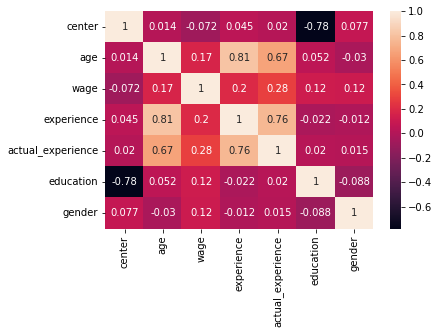

In [ ]:
import seaborn as sns

sns.heatmap(df.corr(),annot=True)

#il manque race : mais biaisé, manque de représentation 
'''
df['race']=df_race['race']
df_r = df['race'].astype(float)
df['race']=df_r
'''

The correlation matrix allow us to have some deduction. Indeed we can see the fact that wage is indeed correlated with all features, and more especialy with the actual_experience. Moreover we can add the fact that all the other features have the same influence on wage. Thus gender have the same incidence than the level of education or the global experience. 


# Clustering

In [ ]:
from sklearn.cluster import KMeans

We can try to make a clustering. We know that there are 8 differents categories of actual_experience and experience.







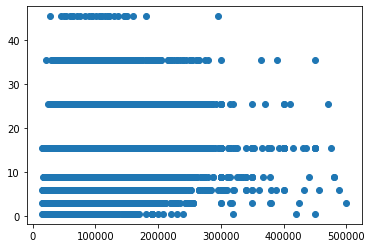

In [ ]:
plt.scatter(df.wage,df.actual_experience)

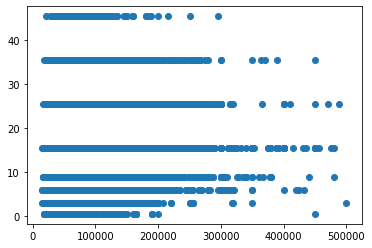

In [ ]:
plt.scatter(df.wage,df.experience)

In [ ]:
df1=df

In [ ]:
data = df1.drop(['race','city','state','country','currency','job','industry','date','wage','actual_experience','experience'], axis=1)
print(data)
data =  data.to_numpy()
kmeans = KMeans(init='k-means++', n_clusters=8, max_iter=10000, n_init=1000).fit(data)

        age  education  gender
0      49.5        2.0     0.0
1      49.5        0.0     0.0
2      39.5        4.0     0.0
3      21.0        4.0     0.0
4      39.5        4.0     0.0
...     ...        ...     ...
22356  29.5        2.0     0.0
22357  39.5        2.0     0.0
22358  39.5        2.0     0.0
22359  29.5        2.0     0.0
22360  39.5        5.0     0.0

[22203 rows x 3 columns]


[2 2 1 ... 6 5 1]


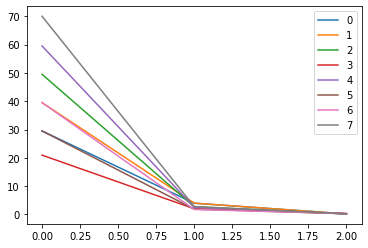

In [ ]:
print(kmeans.labels_)

res = kmeans.cluster_centers_

new_res = res.T
dataframe = pd.DataFrame(new_res)
dataframe.plot()

In [ ]:
clusterwise_sse = 0 
for point, label in zip(data, kmeans.labels_):
    clusterwise_sse += np.square(point - res[label]).sum()

print(clusterwise_sse)

16714.56671765322


In [ ]:
df1.insert(1,'center', kmeans.labels_)

In [ ]:
df1_center = df1.groupby(['center','actual_experience'])
df1_center.size()

center  actual_experience
0       0.5                   222
        3.0                  1238
        6.0                  1403
        9.0                   809
        15.5                  177
        25.5                    2
        35.5                    2
1       0.5                    55
        3.0                   364
        6.0                   697
        9.0                   959
        15.5                 1757
        25.5                  106
        45.5                    2
2       0.5                    27
        3.0                   151
        6.0                   226
        9.0                   273
        15.5                  913
        25.5                  924
        35.5                   60
3       0.5                   351
        3.0                   503
        6.0                    37
        9.0                     1
        15.5                    1
        25.5                    1
        35.5                    1
        45.5          